In [ ]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras

%matplotlib inline

In [ ]:
# Check if GPU available
!nvidia-smi

Fri Mar 25 07:48:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Inception

In [ ]:
# Configure variables for Transfer learning
image_size = 256
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

## Using ImageDataGenerator for Data Loading and Preprocessing

The Tensorflow and Keras API provides `ImageDataGenerator` for adding the augmentations on the images, and easily load them from the directory. This automatically keeps track of the class for each image and works seamlessly with the rest of the API.

In [ ]:
dataset_grapes= "/kaggle/input/grapes-dataset"
train_dir = os.path.join(dataset_grapes, "train_grapes")
test_dir = os.path.join(dataset_grapes, "val_grapes")

In [ ]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Reading data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 7222 images belonging to 4 classes.


In [ ]:
train_data

In [ ]:
diseases = train_data.class_indices
count=0
for i in diseases:
    print(i)
    count+=1
print(count,"classes")

Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grape___healthy
4 classes


In [ ]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [ ]:
print(f"Unique Plants are: \n{plants}")
print("Number of plants: {}".format(len(plants)))

Unique Plants are: 
['Grape']
Number of plants: 1


In [ ]:
print("Number of diseases: {}".format(NumberOfDiseases))


Number of diseases: 3


In [ ]:
# list of categories in training data
cats = list(train_data.class_indices.keys())

In [ ]:
# Augmentations on test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 1805 images belonging to 4 classes.


Number of images of Grape___healthy: 1692 || Number of images of Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722 || Number of images of Grape___Black_rot: 1888 || Number of images of Grape___Esca_(Black_Measles): 1920 || Total number of images we have 7222


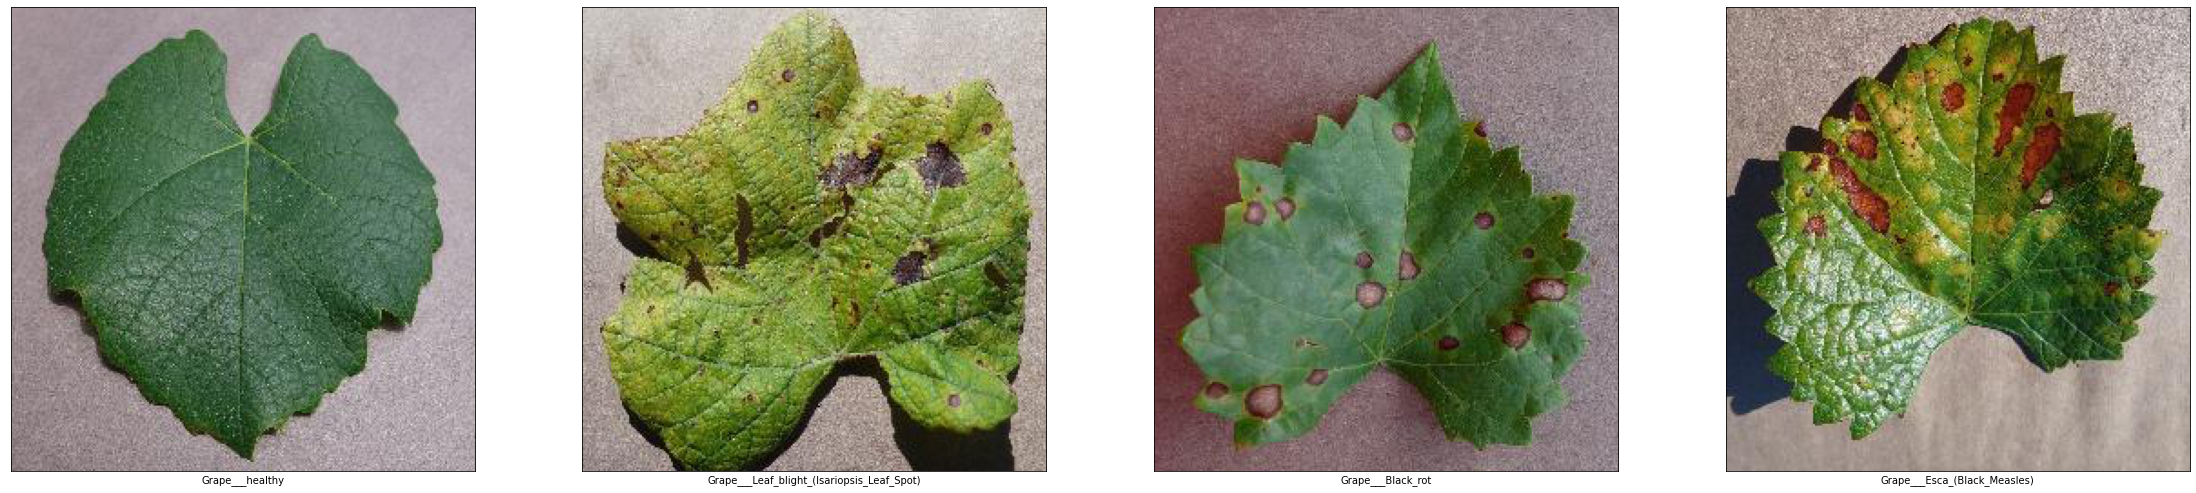

In [ ]:
path='/kaggle/input/grapes-dataset/train_grapes'
plt.figure(figsize=(70,70))
count=0
plant_names=[]
total_images=0
for i in os.listdir(path):
  count+=1
  plant_names.append(i)
  plt.subplot(7,7,count)

  images_path=os.listdir(path+"/"+i)
  print("Number of images of "+i+":",len(images_path),"||",end=" ")
  total_images+=len(images_path)

  image_show=plt.imread(path+"/"+i+"/"+images_path[0])
  
  plt.imshow(image_show)
  plt.xlabel(i)
  
  plt.xticks([])
  plt.yticks([])


print("Total number of images we have",total_images)


Text(0.5, 1.0, 'Images per each class of plant disease')

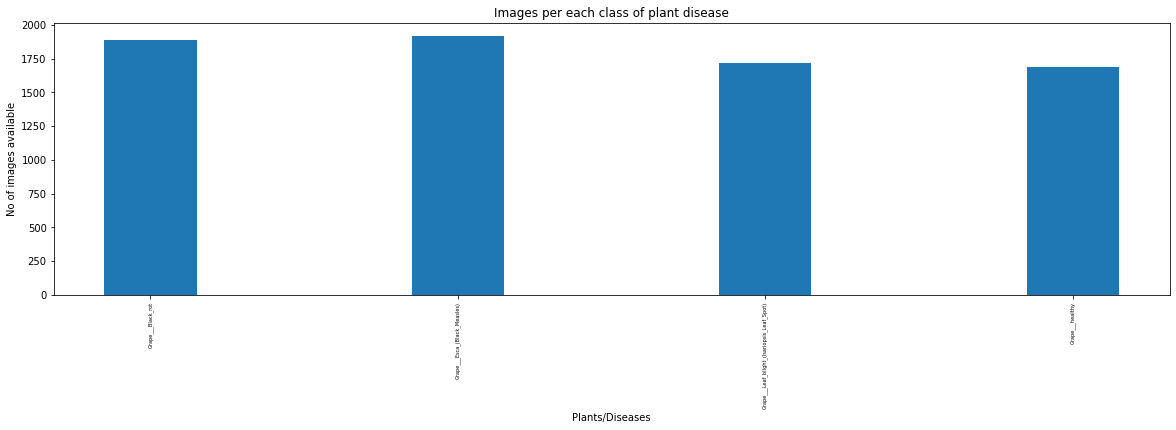

In [ ]:
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
index = [n for n in range(4)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [ ]:
# Load the base model
incept_v3 = keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
incept_v3.trainable = True

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = incept_v3(inputs, training = True)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 21,810,980
Trainable params: 21,776,548
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
filepath='plant_disease_detection_incept.h5'
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Num epochs
epochs = 25

# Train model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=callbacks_list
)

Epoch 1/25
150/150 [==============================] - 124s 739ms/step - loss: 0.3091 - accuracy: 0.8903 - val_loss: 0.0614 - val_accuracy: 0.9812

Epoch 00001: val_accuracy improved from -inf to 0.98116, saving model to plant_disease_detection_incept.h5
Epoch 2/25
150/150 [==============================] - 91s 608ms/step - loss: 0.0417 - accuracy: 0.9880 - val_loss: 0.0261 - val_accuracy: 0.9928

Epoch 00002: val_accuracy improved from 0.98116 to 0.99280, saving model to plant_disease_detection_incept.h5
Epoch 3/25
150/150 [==============================] - 88s 587ms/step - loss: 0.0399 - accuracy: 0.9873 - val_loss: 0.0169 - val_accuracy: 0.9950

Epoch 00003: val_accuracy improved from 0.99280 to 0.99501, saving model to plant_disease_detection_incept.h5
Epoch 4/25
150/150 [==============================] - 88s 586ms/step - loss: 0.0632 - accuracy: 0.9801 - val_loss: 0.0165 - val_accuracy: 0.9967

Epoch 00004: val_accuracy improved from 0.99501 to 0.99668, saving model to plant_diseas

In [ ]:
model.evaluate(test_data)

57/57 [==============================] - 6s 99ms/step - loss: 0.0020 - accuracy: 1.0000


[0.001999625936150551, 1.0]

## Visualize the model history

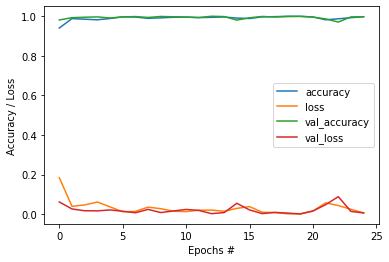

In [ ]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

## Save and download the model


In [ ]:
import json

from IPython.display import FileLink

# Link the files
FileLink("./plant_disease_detection_incept.h5")

/kaggle/working/plant_disease_detection_incept.h5

# ResNet50

In [ ]:
Resnet50 = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
Resnet50.trainable = True

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# Define the layers
inputs = keras.Input(shape=(256,256,3))

# Get the layer
x = Resnet50(inputs, training = True)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
filepath='plant_disease_detection_Resnet50.h5'
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Num epochs
epochs = 25

# Train model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=callbacks_list
)

Epoch 1/25
150/150 [==============================] - 98s 618ms/step - loss: 0.4025 - accuracy: 0.8861 - val_loss: 0.0770 - val_accuracy: 0.9773

Epoch 00001: val_accuracy improved from -inf to 0.97729, saving model to plant_disease_detection_Resnet50.h5
Epoch 2/25
150/150 [==============================] - 91s 606ms/step - loss: 0.0820 - accuracy: 0.9758 - val_loss: 0.0476 - val_accuracy: 0.9873

Epoch 00002: val_accuracy improved from 0.97729 to 0.98726, saving model to plant_disease_detection_Resnet50.h5
Epoch 3/25
150/150 [==============================] - 92s 613ms/step - loss: 0.0638 - accuracy: 0.9810 - val_loss: 0.0569 - val_accuracy: 0.9823

Epoch 00003: val_accuracy did not improve from 0.98726
Epoch 4/25
150/150 [==============================] - 92s 609ms/step - loss: 0.0553 - accuracy: 0.9795 - val_loss: 0.1138 - val_accuracy: 0.9690

Epoch 00004: val_accuracy did not improve from 0.98726
Epoch 5/25
150/150 [==============================] - 91s 610ms/step - loss: 0.0552 -

In [ ]:
model.evaluate(test_data)

57/57 [==============================] - 6s 102ms/step - loss: 0.0156 - accuracy: 0.9950


[0.01558967400342226, 0.9950138330459595]

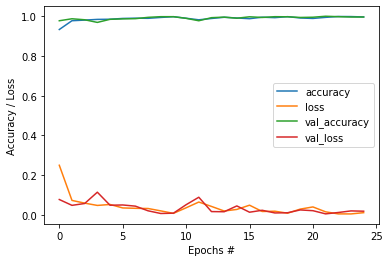

In [ ]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [ ]:
FileLink("./plant_disease_detection_Resnet50.h5")

/kaggle/working/plant_disease_detection_Resnet50.h5

# MobileNetv2

In [ ]:
mb_net = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(256,256,3)
)

# Stop from being trainable
mb_net.trainable = True

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# Define the layers
inputs = keras.Input(shape=(256,256,3))

# Get the layer
x = mb_net(inputs, training = True)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 2,228,996
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
filepath='plant_disease_detection_mbnet.h5'
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Num epochs
epochs = 25

# Train model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=callbacks_list
)

Epoch 1/25
150/150 [==============================] - 96s 604ms/step - loss: 0.2310 - accuracy: 0.9231 - val_loss: 0.0466 - val_accuracy: 0.9861

Epoch 00001: val_accuracy improved from -inf to 0.98615, saving model to plant_disease_detection_mbnet.h5
Epoch 2/25
150/150 [==============================] - 92s 616ms/step - loss: 0.0344 - accuracy: 0.9913 - val_loss: 0.0504 - val_accuracy: 0.9828

Epoch 00002: val_accuracy did not improve from 0.98615
Epoch 3/25
150/150 [==============================] - 92s 614ms/step - loss: 0.0625 - accuracy: 0.9835 - val_loss: 0.0165 - val_accuracy: 0.9934

Epoch 00003: val_accuracy improved from 0.98615 to 0.99335, saving model to plant_disease_detection_mbnet.h5
Epoch 4/25
150/150 [==============================] - 90s 599ms/step - loss: 0.0330 - accuracy: 0.9905 - val_loss: 0.0139 - val_accuracy: 0.9961

Epoch 00004: val_accuracy improved from 0.99335 to 0.99612, saving model to plant_disease_detection_mbnet.h5
Epoch 5/25
150/150 [=================

In [ ]:
model.evaluate(test_data)

57/57 [==============================] - 5s 91ms/step - loss: 0.0043 - accuracy: 0.9989


[0.004318886902183294, 0.9988919496536255]

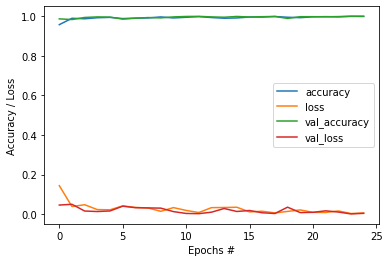

In [ ]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [ ]:
FileLink("./plant_disease_detection_mbnet.h5")

/kaggle/working/plant_disease_detection_mbnet.h5

# Xception

In [ ]:
xception = tf.keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(256,256,3)
)

# Stop from being trainable
xception.trainable = True

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
# Define the layers
inputs = keras.Input(shape=(256,256,3))

# Get the layer
x = xception(inputs, training = True)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
filepath='plant_disease_detection_xception.h5'
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Num epochs
epochs = 25

# Train model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=callbacks_list
)

Epoch 1/25
150/150 [==============================] - 119s 761ms/step - loss: 0.2155 - accuracy: 0.9251 - val_loss: 0.0762 - val_accuracy: 0.9762

Epoch 00001: val_accuracy improved from -inf to 0.97618, saving model to plant_disease_detection_xception.h5
Epoch 2/25
150/150 [==============================] - 113s 753ms/step - loss: 0.0354 - accuracy: 0.9889 - val_loss: 0.0378 - val_accuracy: 0.9889

Epoch 00002: val_accuracy improved from 0.97618 to 0.98892, saving model to plant_disease_detection_xception.h5
Epoch 3/25
150/150 [==============================] - 114s 756ms/step - loss: 0.0280 - accuracy: 0.9918 - val_loss: 0.0376 - val_accuracy: 0.9900

Epoch 00003: val_accuracy improved from 0.98892 to 0.99003, saving model to plant_disease_detection_xception.h5
Epoch 4/25
150/150 [==============================] - 114s 757ms/step - loss: 0.0178 - accuracy: 0.9936 - val_loss: 0.0219 - val_accuracy: 0.9945

Epoch 00004: val_accuracy improved from 0.99003 to 0.99446, saving model to pla

In [ ]:
model.evaluate(test_data)

57/57 [==============================] - 7s 115ms/step - loss: 0.0175 - accuracy: 0.9961


[0.01751127280294895, 0.996121883392334]

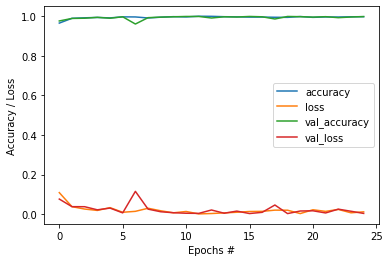

In [ ]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [ ]:
FileLink("./plant_disease_detection_xception.h5")

/kaggle/working/plant_disease_detection_xception.h5

# EfficientNet

In [ ]:
# Load the base model
efnet = tf.keras.applications.EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=(256,256,3)
)

# Stop from being trainable
efnet.trainable = True

43941888/43941136 [==============================] - 1s 0us/step


In [ ]:
# Define the layers
inputs = keras.Input(shape=(256,256,3))

# Get the layer
x = efnet(inputs, training = True)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 8, 8, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 6148      
Total params: 10,789,683
Trainable params: 10,702,380
Non-trainable params: 87,303
_________________________________________________________________


In [ ]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
filepath='plant_disease_detection_effnet.h5'
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Num epochs
epochs = 25

# Train model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=callbacks_list
)

Epoch 1/25
150/150 [==============================] - 129s 773ms/step - loss: 0.2076 - accuracy: 0.9244 - val_loss: 0.0699 - val_accuracy: 0.9801

Epoch 00001: val_accuracy improved from -inf to 0.98006, saving model to plant_disease_detection_effnet.h5
Epoch 2/25
150/150 [==============================] - 119s 790ms/step - loss: 0.0556 - accuracy: 0.9819 - val_loss: 0.0095 - val_accuracy: 0.9972

Epoch 00002: val_accuracy improved from 0.98006 to 0.99723, saving model to plant_disease_detection_effnet.h5
Epoch 3/25
150/150 [==============================] - 118s 788ms/step - loss: 0.0239 - accuracy: 0.9944 - val_loss: 0.0113 - val_accuracy: 0.9972

Epoch 00003: val_accuracy did not improve from 0.99723
Epoch 4/25
150/150 [==============================] - 117s 777ms/step - loss: 0.0140 - accuracy: 0.9959 - val_loss: 0.0301 - val_accuracy: 0.9861

Epoch 00004: val_accuracy did not improve from 0.99723
Epoch 5/25
150/150 [==============================] - 115s 768ms/step - loss: 0.0511 

In [ ]:
model.evaluate(test_data)

57/57 [==============================] - 7s 116ms/step - loss: 0.0191 - accuracy: 0.9956


[0.01907331496477127, 0.9955678582191467]

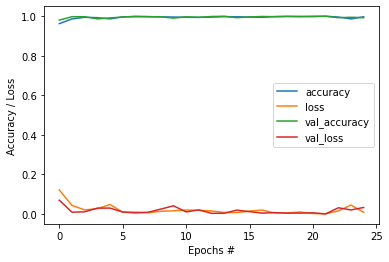

In [ ]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [ ]:
FileLink("./plant_disease_detection_effnet.h5")

/kaggle/working/plant_disease_detection_effnet.h5

# Custom Model

In [ ]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
model.add(layers.Conv2D(32,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256,(3,3),activation='relu'))
model.add(layers.Conv2D(256,(3,3),activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(len(cats), activation="softmax"))

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
filepath='plant_disease_detection_custom.h5'
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Num epochs
epochs = 25

# Train model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=callbacks_list
)

Epoch 1/25
150/150 [==============================] - 86s 562ms/step - loss: 1.3280 - accuracy: 0.2978 - val_loss: 1.2822 - val_accuracy: 0.2870

Epoch 00001: val_accuracy improved from -inf to 0.28698, saving model to plant_disease_detection_custom.h5
Epoch 2/25
150/150 [==============================] - 84s 562ms/step - loss: 1.0025 - accuracy: 0.4961 - val_loss: 1.3289 - val_accuracy: 0.4632

Epoch 00002: val_accuracy improved from 0.28698 to 0.46316, saving model to plant_disease_detection_custom.h5
Epoch 3/25
150/150 [==============================] - 81s 540ms/step - loss: 0.7720 - accuracy: 0.6731 - val_loss: 0.7668 - val_accuracy: 0.7169

Epoch 00003: val_accuracy improved from 0.46316 to 0.71690, saving model to plant_disease_detection_custom.h5
Epoch 4/25
150/150 [==============================] - 81s 540ms/step - loss: 0.6423 - accuracy: 0.7470 - val_loss: 0.7832 - val_accuracy: 0.7075

Epoch 00004: val_accuracy did not improve from 0.71690
Epoch 5/25
150/150 [==============

In [ ]:
FileLink("./plant_disease_detection_custom.h5")

/kaggle/working/plant_disease_detection_custom.h5